# 

# Transfer Learning on kermany18 OCT dataset using VGG16

We attempt to perform classification on the RET OCT2017 (kermany18) dataset by leveraging transfer learning using the VGG16 model pretrained on imagenet. We freeze all the layers except the top and train on the dataset using class weights to prevent class imbalance.

Dataset consists of 4 classes: CNV, DME, DRUSEN, NORMAL

Due to large amount of data having white patches and unequal sizes, we only extract images without these artifacts. To prevent extreme imbalance we only extract around 1000 images per class for train set and around 200 for test set.

Our observations are that model overfits to the data, giving 85% test set accuracy.
We display classification report, accuracy and loss graphs, ros curves for each class and confusion matrix.

In [2]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

### Loading the dataset

In [3]:
train_path = "/kaggle/input/kermany2018/OCT2017 /train"
test_path = "/kaggle/input/kermany2018/OCT2017 /test"
dir_name = os.listdir(train_path)

In [4]:
train = defaultdict(list)
test = defaultdict(list)
train_label = defaultdict(list)
test_label = defaultdict(list)

from tqdm import tqdm
for i in range(4):
    path = os.path.join(train_path, dir_name[i])
    for j in tqdm(os.listdir(path)):
        im = np.array(Image.open(os.path.join(path, j)))
        if im.shape == (496, 768):
            train[str(dir_name[i])].append(os.path.join(path, j))
            train_label[str(dir_name[i])].append(dir_name[i])

for i in range(4):
    path = os.path.join(test_path, dir_name[i])
    for j in tqdm(os.listdir(path)):
        im = np.array(Image.open(os.path.join(path, j)))
        if im.shape == (496, 768):
            test[str(dir_name[i])].append(os.path.join(path, j))
            test_label[str(dir_name[i])].append(dir_name[i])

100%|██████████| 242/242 [00:02<00:00, 101.20it/s]


In [5]:
print("Train set distribution")
for i in dir_name:
    print(i,len(train[str(i)]))
print("Test set distribution")
for i in dir_name: 
    print(i,len(test[str(i)]))

Train set distribution
DRUSEN 2531
CNV 12050
NORMAL 6088
DME 816
Test set distribution
DRUSEN 36
CNV 65
NORMAL 15
DME 106


In [6]:
# Assigning equal amount of data per class to both train and test
train_path = []
train_class = []
test_path = []
test_class = []

for i in range(3):
    temp  = list(zip(train[dir_name[i]], train_label[dir_name[i]]))
    random.shuffle(temp)
    res1, res2 = zip(*temp)
    train_path.extend(res1[0:1000])
    train_class.extend(res2[0:1000])
    
    test_path.extend(res1[1000:1200])
    test_class.extend(res2[1000:1200])
    
train_path.extend(train[dir_name[3]])
train_class.extend(train_label[dir_name[3]])
test_path.extend(test[dir_name[3]])
test_class.extend(test_label[dir_name[3]])

In [7]:
df_train = pd.DataFrame(list(zip(train_path, train_class)),
               columns =['image_path', 'label'])

df_test = pd.DataFrame(list(zip(test_path, test_class)),
               columns =['image_path', 'label'])

### Train/Test Distribution

<AxesSubplot:xlabel='label', ylabel='count'>

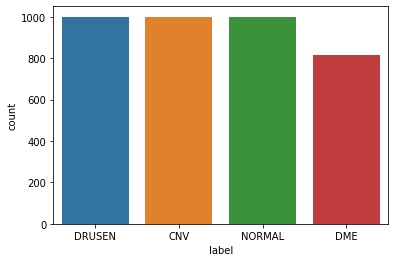

In [8]:
df = df_train
lab = df['label']
dist = lab.value_counts()
sns.countplot(x = lab)

<AxesSubplot:xlabel='label', ylabel='count'>

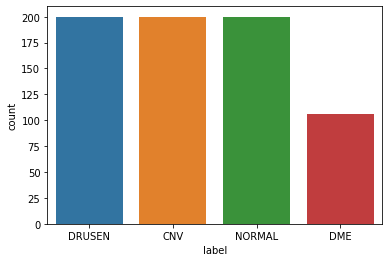

In [9]:
df = df_test
lab = df['label']
dist = lab.value_counts()
sns.countplot(x = lab)

### Data generator, augmentations

In [10]:
train_aug = ImageDataGenerator(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    rescale = 1./255)

test_aug = ImageDataGenerator(
    rescale = 1./255)

train_generator= train_aug.flow_from_dataframe(
dataframe=df_train,
x_col="image_path",
y_col="label",
batch_size=32,
color_mode="rgb",
shuffle = True,
target_size = (224, 224),
class_mode="categorical")

test_generator= test_aug.flow_from_dataframe(
dataframe=df_test,
x_col="image_path",
y_col="label",
color_mode="rgb",
batch_size=32,
shuffle = False, #I set to False for classification report
target_size = (224, 224),
class_mode="categorical")

Found 3816 validated image filenames belonging to 4 classes.
Found 706 validated image filenames belonging to 4 classes.


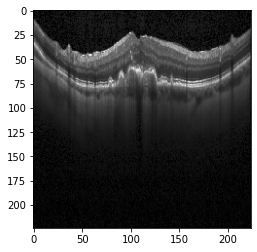

In [11]:
import matplotlib.pyplot as plt
plt.imshow(test_generator[0][0][2])

### Adding Class weights

In [12]:
from sklearn.utils import class_weight
map_characters = train_generator.class_indices
print(map_characters)
class_weights = dict(zip(map_characters.values(), class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_class), 
                y=train_class))) 
print("Class Weights: ",class_weights)

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
Class Weights:  {0: 0.954, 1: 1.1691176470588236, 2: 0.954, 3: 0.954}


### Build Model

In [13]:
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3

def generate_model(pretrained_model = 'vgg16', num_classes = 4):
    if pretrained_model == 'inceptionv3':
        weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
        base_model = InceptionV3(weights = weight_path, include_top=False, input_shape=(224, 224, 3))
    else:
        weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        base_model = VGG16(weights = weight_path, include_top=False, input_shape=(224, 224, 3)) # Topless
    
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
        
    return model

model = generate_model("vgg16", 4)

### Training model

In [14]:
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
    factor=0.1,
    patience=4)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=7, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=test_generator, class_weight = class_weights, epochs = 50, callbacks = [rlr, early_stop])

Epoch 1/50
120/120 [==============================] - 69s 495ms/step - loss: 1.2505 - accuracy: 0.4862 - val_loss: 0.8029 - val_accuracy: 0.6827
Epoch 2/50
120/120 [==============================] - 58s 485ms/step - loss: 0.6222 - accuracy: 0.7526 - val_loss: 0.5373 - val_accuracy: 0.7960
Epoch 3/50
120/120 [==============================] - 57s 476ms/step - loss: 0.5525 - accuracy: 0.7995 - val_loss: 0.5811 - val_accuracy: 0.7946
Epoch 4/50
120/120 [==============================] - 58s 480ms/step - loss: 0.4878 - accuracy: 0.8187 - val_loss: 0.7299 - val_accuracy: 0.7408
Epoch 5/50
120/120 [==============================] - 58s 480ms/step - loss: 0.4431 - accuracy: 0.8269 - val_loss: 0.4619 - val_accuracy: 0.8187
Epoch 6/50
120/120 [==============================] - 58s 480ms/step - loss: 0.3752 - accuracy: 0.8689 - val_loss: 0.4286 - val_accuracy: 0.8442
Epoch 7/50
120/120 [==============================] - 58s 483ms/step - loss: 0.3151 - accuracy: 0.8878 - val_loss: 0.4469 - val_ac

### Plot Accuracy and Loss Graphs

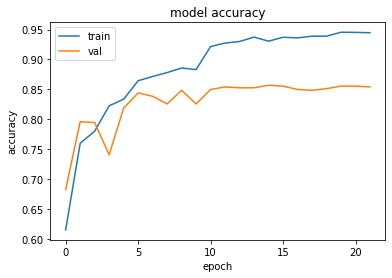

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

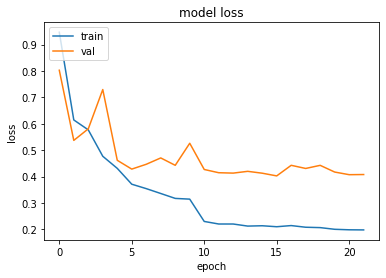

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Classification Report

In [17]:
from sklearn import metrics
y_true = np.array(test_generator.labels)
y_pred = model.predict(test_generator, verbose = 1)
y_pred_classes = np.argmax(y_pred,axis = 1)
class_labels = list(test_generator.class_indices.keys())   

23/23 [==============================] - 4s 158ms/step


In [18]:
print('\n', metrics.classification_report(y_true, y_pred_classes, target_names=class_labels), sep='')


              precision    recall  f1-score   support

         CNV       0.93      0.82      0.87       200
         DME       0.85      0.92      0.88       106
      DRUSEN       0.81      0.77      0.79       200
      NORMAL       0.84      0.94      0.88       200

    accuracy                           0.85       706
   macro avg       0.86      0.86      0.86       706
weighted avg       0.86      0.85      0.85       706



### ROC Curves

In [21]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

def plot_roc_curves(y_true, y_pred, num_classes, class_labels):

    lb = LabelBinarizer()
    lb.fit(y_true)
    y_test = lb.transform(y_true)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # Plot all ROC curves
    for i in range(num_classes):
        fig, c_ax = plt.subplots(1,1, figsize = (6, 4))
        c_ax.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.4f})'
                 ''.format(class_labels[i], roc_auc[i]))
        c_ax.set_xlabel('False Positive Rate')
        c_ax.set_ylabel('True Positive Rate')
        c_ax.set_title('ROC curve of class {0}'.format(class_labels[i]))
        c_ax.legend(loc="lower right")
        plt.show()

    return roc_auc_score(y_test, y_pred)

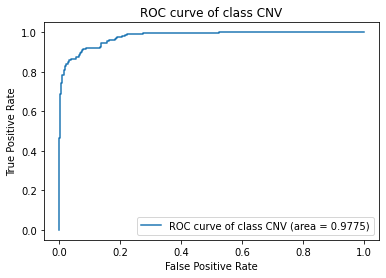

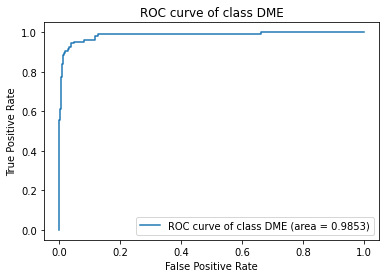

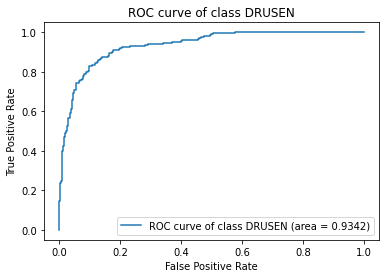

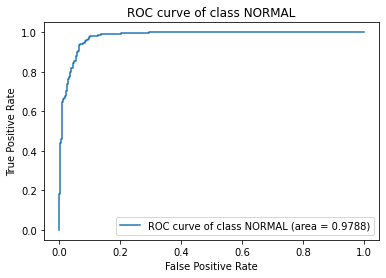

ROS AUC score: 0.9689506736768837


In [22]:
print("ROS AUC score:", plot_roc_curves(y_true, y_pred, 4, class_labels))

### Confusion matrix

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

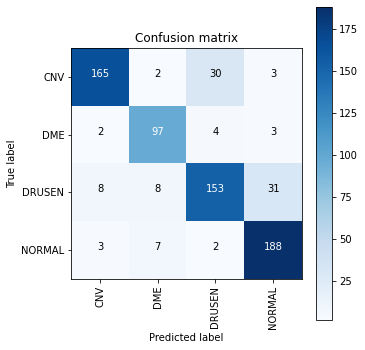

In [24]:
from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.keys()))
plt.show()